In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from math import sqrt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import RANSACRegressor, HuberRegressor, LinearRegression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.decomposition import PCA


## 1. Cargando los datos

In [2]:
dataset = pd.read_csv('..\datos_procesados\datos_procesados.csv')
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,20,0,80.0,9600,0,0,0,0,1,0,...,0,0,0,0,0,5,2007,0,0,181500
2,60,0,68.0,11250,0,0,1,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,70,0,60.0,9550,0,0,1,0,2,0,...,0,0,0,0,0,2,2006,0,1,140000
4,60,0,84.0,14260,0,0,1,0,1,0,...,0,0,0,0,0,12,2008,0,0,250000


## 2. Definiendo los features y la variable a predecir

In [3]:
X = dataset.drop(['SalePrice'], axis=1)
y = dataset[['SalePrice']]

## 3. Se realiza el escalamiento de los datos

In [4]:
escalador_robuto = RobustScaler()
X_escalado = escalador_robuto.fit_transform(X=X)
print('Forma de la variable X_escalado: {}'.format(X_escalado.shape))

Forma de la variable X_escalado: (1121, 78)


## 4. RANSAC

In [12]:
r2_ransac = []

for num_comp in range(1, (X_escalado.shape[1]+1)):
    pca = PCA(n_components=num_comp)
    X_pca = pca.fit_transform(X_escalado)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

    #Creando el regresor y entrenandolo
    ransac = RANSACRegressor(max_trials=100)
    ransac.fit(X=X_train, y=y_train)

    #Verificando el error en el entrenamiento
    y_pred_ransac = ransac.predict(X_test)
    r2_ransac.append(r2_score(y_true=y_test, y_pred=y_pred_ransac))

max_r2_ransac = max(r2_ransac)
max_r2_comp_ransac = r2_ransac.index(max_r2_ransac)
print('max R^2 test: {:.2f}\tNumero componentes: {}'.format(max_r2_ransac, max_r2_comp_ransac))   

max R^2 test: 0.84	Numero componentes: 76


#### 4.1 Cómo el $R^2 score$ más alto se obtuvo como 76 componentes, se crea el modelo a partir de ese número de insights

In [25]:
#Se reduce la dimensionalidad a 76
num_componentes = 76
pca = PCA(n_components=num_componentes)
X_pca = pca.fit_transform(X_escalado)

#Se divide los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

#Creando el regresor y entrenandolo
ransac = RANSACRegressor(max_trials=100)
ransac.fit(X=X_train, y=y_train)

print("R^2 test: {:.2f}".format(r2_score(y_true=y_test, y_pred=ransac.predict(X_test))))
print("R^2 train: {:.2f}".format(r2_score(y_true=y_train, y_pred=ransac.predict(X_train))))

print("\nRMSR test: +- {:.0f} USD".format(sqrt(mean_squared_error(y_true=y_test, y_pred=ransac.predict(X_test)))))
print("RMSR train: +- {:.0f} USD".format(sqrt(mean_squared_error(y_true=y_train, y_pred=ransac.predict(X_train)))))

R^2 test: 0.81
R^2 train: 0.73

RMSR test: +- 38478 USD
RMSR train: +- 41804 USD


In [18]:
df_comp_price = y_test.copy()
df_comp_price['y_pred_ransac'] = np.round(ransac.predict(X_test), decimals=0)

## 5. HUBER

#### 5.1 Número de componentes más optimo para obtener un mejor $R^2 score$ con HUBER

In [19]:
r2_huber = []

for num_comp in range(1, (X_escalado.shape[1]+1)):
    pca = PCA(n_components=num_comp)
    X_pca = pca.fit_transform(X_escalado)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

    #Creando el regresor y entrenandolo
    huber = HuberRegressor(epsilon=1.35)
    huber.fit(X=X_train, y=y_train)

    #Verificando el puntaje r^2 en la predicción 
    r2_huber.append(r2_score(y_true=y_test, y_pred=huber.predict(X_test)))

max_r2_huber = max(r2_huber)
max_r2_comp_huber = r2_huber.index(max_r2_huber)
print('max R^2 test: {:.2}\tNumero componentes: {}'.format(max_r2_huber, max_r2_comp_huber))  

max R^2 test: 0.86	Numero componentes: 55


#### 5.2 Cómo el $R^2 score$ más alto se obtuvo como 55 componentes, se crea el modelo a partir de ese número de insights

In [37]:
#Se reduce la dimensionalidad a 55
num_componentes = 55
pca = PCA(n_components=num_componentes)
X_pca = pca.fit_transform(X_escalado)

#Se divide los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

#Creando el regresor y entrenandolo
huber = HuberRegressor(epsilon=1.35)
huber.fit(X=X_train, y=y_train)

print("R^2 test: {:.2f}".format(r2_score(y_true=y_test, y_pred=huber.predict(X_test))))
print("R^2 train: {:.2f}".format(r2_score(y_true=y_train, y_pred=huber.predict(X_train))))

print("\nRMSR test: +- {:.0f} USD".format(sqrt(mean_squared_error(y_true=y_test, y_pred=huber.predict(X_test)))))
print("RMSR train: +- {:.0f} USD".format(sqrt(mean_squared_error(y_true=y_train, y_pred=huber.predict(X_train)))))

R^2 test: 0.84
R^2 train: 0.75

RMSR test: +- 36119 USD
RMSR train: +- 40056 USD


## 6. Comparación de los algoritmos de RANSAC y HUBER en la predicción del precio de las viviendas

In [38]:
df_comp_price['y_pred_huber'] = np.round(huber.predict(X_test), decimals=0)
df_comp_price

,SalePrice,y_pred_ransac,y_pred_huber
996,140000,190436.0,158189.0
101,150750,132554.0,145383.0
231,157000,189650.0,151798.0
1004,138000,155299.0,143814.0
605,144000,129047.0,166595.0
...,...,...,...
787,87000,154033.0,91697.0
939,112000,119314.0,128948.0
428,255500,251055.0,274308.0
693,122900,46496.0,144307.0


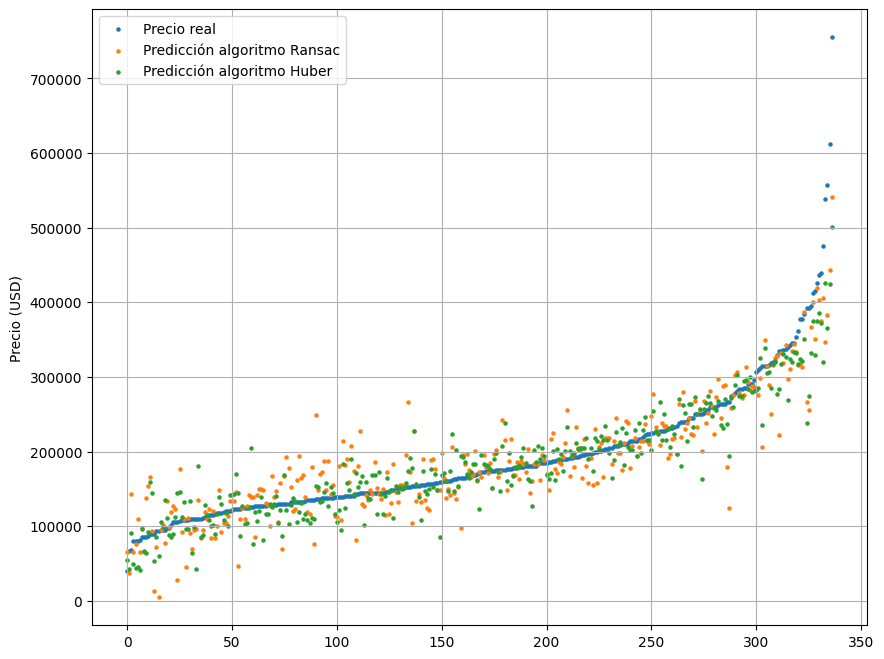

In [40]:
df_comp_price.sort_values('SalePrice', inplace=True)
x = range(len(df_comp_price['SalePrice'].to_list()))
size_dot = 5
plt.figure(figsize=(10,8))
plt.scatter(x, df_comp_price['SalePrice'], label='Precio real', s=size_dot)
plt.scatter(x, df_comp_price['y_pred_ransac'], label='Predicción algoritmo Ransac', s=size_dot)
plt.scatter(x, df_comp_price['y_pred_huber'], label='Predicción algoritmo Huber', s=size_dot)
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()
plt.show()